## Nino 3.4 and AVISO Composites

<div class="alert alert-block alert-info">
Import Necessary Modules
</div>

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

<div class="alert alert-block alert-info">
Import Data and Indices
</div>

In [12]:
# Import Nino 3.4 Data
file_nino34='/scratch/kpegion/nino34_1982-2019.oisstv2_anoms.nc'
ds_nino34=xr.open_dataset(file_nino34)
ds_nino34

<xarray.Dataset>
Dimensions:  (time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
    month    (time) int64 ...
Data variables:
    sst      (time) float32 ...

In [13]:
# Import AVISO Data
ds_aviso=xr.open_dataset('monthly_aviso.nc')
ds_aviso

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 276)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
Data variables:
    sla        (time, latitude, longitude) float64 ...

### Data Preperation

In [14]:
# Slice Nino 3.4 data to match AVISO
ds_nino34=ds_nino34.sel(time=slice(ds_aviso['time'][0],ds_aviso['time'][-1]))
ds_nino34

<xarray.Dataset>
Dimensions:  (time: 276)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 0.1387 0.2251 0.4108 0.7553 ... 2.416 2.855 2.737

### Define El Nino, Neutral, and La Nina

Nino3.4 >= 1 -> El Nino

Nino3.4 <= -1 -> La Nina

Nino3.4 > -1 and Nino3.4 < 1 -> Neutral

In [15]:
elnino=ds_nino34['sst'].where(ds_nino34['sst']>=1)
lanina=ds_nino34['sst'].where(ds_nino34['sst']<=-1)
neutral=ds_nino34['sst'].where(np.logical_and(ds_nino34['sst']>-1,
                                              ds_nino34['sst']<1))

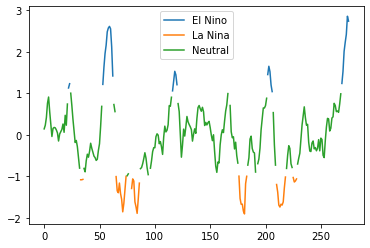

In [16]:
plt.plot(elnino)
plt.plot(lanina)
plt.plot(neutral)
plt.legend(['El Nino', 'La Nina', 'Neutral'])

#### How Many Months in Each?

In [23]:
print('El Nino: ',elnino.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('La Nina: ',lanina.count(dim='time').values)

counts=[elnino.count(dim='time').values,
        neutral.count(dim='time').values,
        lanina.count(dim='time').values]
print(counts)

El Nino:  30
Neutral:  201
La Nina:  45
[array(30), array(201), array(45)]


#### Make Anomalies

In [24]:
ds_climo=ds_aviso.groupby('time.month').mean()
ds_anoms=ds_aviso.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 276)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sla        (time, latitude, longitude) float64 -0.01249 -0.01437 ... nan nan

#### Select Dates that match El Nino, Neutral, and La Nina

In [25]:
elnino_sla=ds_anoms.sel(time=elnino.dropna(dim='time')['time']).mean(dim='time')
lanina_sla=ds_anoms.sel(time=lanina.dropna(dim='time')['time']).mean(dim='time')
neutral_sla=ds_anoms.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

comp_sla=[elnino_sla,lanina_sla,neutral_sla]
print(comp_sla)

[<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
Data variables:
    sla        (latitude, longitude) float64 0.007721 0.007851 ... nan nan, <xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
Data variables:
    sla        (latitude, longitude) float64 -0.001516 -0.001956 ... nan nan, <xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
Data variables:
    sla        (latitude, longitude) float64 -0.0008129 -0.0007338 ... nan nan]


### Composite Plotting

Text(0.5, 0.98, 'Composite Sea Level Anomalies during ENSO')

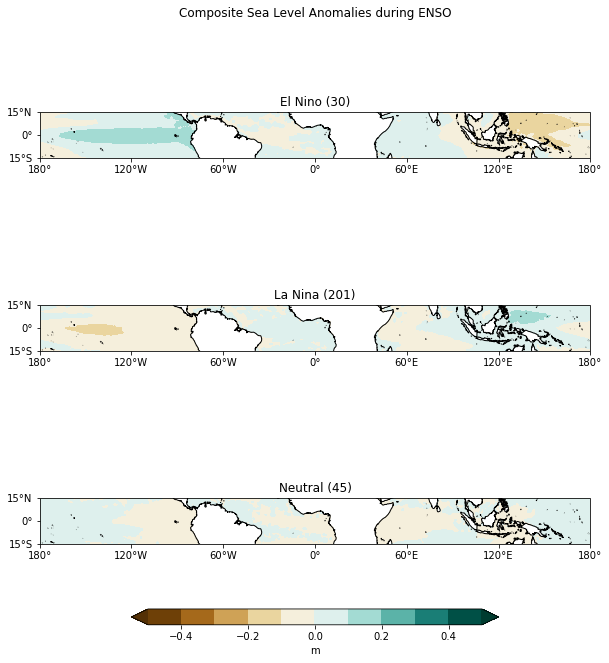

In [44]:
labels=['El Nino','La Nina', 'Neutral']
clevs=np.arange(-0.5,0.6,0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_sla):

        # Select the season
        data=comp_sla[i]['sla']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=comp_sla[i]['longitude'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_sla[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-15,16,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m')

# Add a big title at the top
plt.suptitle('Composite Sea Level Anomalies during ENSO')